In [1]:
from scipy.io import savemat

import pandas as pd
import numpy as np
import pickle as pkl
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import tqdm
import seaborn as sns

from models import MLP, TandemNet, cVAE, cGAN, INN, cVAE_new, cVAE_GSNN
from utils import evaluate_simple_inverse, evaluate_tandem_accuracy, evaluate_vae_inverse, evaluate_vae_minmax_inverse,evaluate_vae_minmax_GSNN_inverse, evaluate_gan_inverse, evaluate_inn_inverse
from configs import get_configs
from plotting_utils import compare_cie_dist, compare_param_dist, plot_cie, plot_cie_raw_pred
from datasets import get_dataloaders, SiliconColor

from sklearn.metrics import r2_score

#DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE = 'cpu'
train_loader, val_loader, test_loader = get_dataloaders('tandem_net')

forward_model = MLP(4, 3).to(DEVICE)
forward_model.load_state_dict(torch.load('./models/forward_model_trained.pth')['model_state_dict'])


<All keys matched successfully>

In [2]:
def evaluate_forward(forward_model, dataset):
    '''
    The dataset need to be in inverse format, i.e., x corresponds to target while y corresponds to design.
    '''

    range_, min_ = torch.tensor(dataset.scaler.data_range_).to(DEVICE), torch.tensor(dataset.scaler.data_min_).to(DEVICE)
    with torch.no_grad():
        x, y = dataset.x.to(DEVICE), dataset.y.to(DEVICE)
        x_dim = x.size()[1]
        M = x.size()[0]
        x_pred = forward_model(y, y)
        x_pred_raw = x_pred *range_[:x_dim] + min_[:x_dim]
        x_raw = x *range_[:x_dim] + min_[:x_dim]
        
    x_pred_raw = x_pred_raw.cpu().numpy()
    x_raw = x_raw.cpu().numpy()
    return  np.reshape(x_pred_raw, (M, -1)), np.reshape(x_raw, (M, -1))


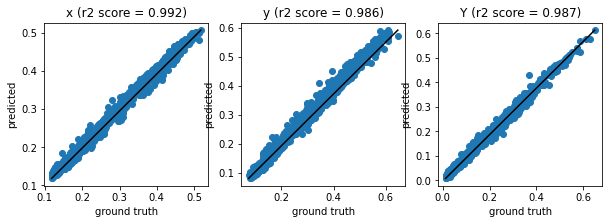

In [3]:
cie_pred, cie_raw = evaluate_forward(forward_model, test_loader.dataset)
plot_cie_raw_pred(cie_raw, cie_pred)